In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.constants
from qutip import *
import random
from numpy.random import choice
import matplotlib.cm as cm
from sympy import *
from IPython.display import Image
from sympy.physics.wigner import wigner_6j
from sympy.physics.quantum.cg import CG
import tqdm
from numpy import random
from scipy.optimize import curve_fit
from matplotlib.cm import ScalarMappable

""" 
constants
"""
pi = np.pi
c = sp.constants.c
epsilon0 = sp.constants.epsilon_0
mu_0 = sp.constants.mu_0
hbar = sp.constants.hbar
h = sp.constants.h
g = sp.constants.g
u = sp.constants.physical_constants['atomic mass constant'][0]
kB = sp.constants.physical_constants['Boltzmann constant'][0]
mB = sp.constants.physical_constants['Bohr magneton'][0]
inch = 25.4e-3

# α/h [Hz/(V/m)2]=2.48832×10−8 α [a.u.] from https://arxiv.org/pdf/1507.06570.pdf
# α [a.u.] = 1.648 777 274 36 x 10-41 α [C2 m2 J-1] #https://physics.nist.gov/cgi-bin/cuu/Value?auepol
a_au = 1.64877727436*1e-41

In [2]:
def Bfield(r, num):
    M = 1.2 #in T (also known as remanance)
    V = 10*25*3e-9 #in m3, volume of magnet stack
    m = num*M*V*np.array([[0, 0, 1], [0, 0, -1],[0, 0, 1], [0, 0, -1]])/mu_0 #magnetic moment of the magnet
    a = 39e-3
    ax = 30e-3
    posm = np.array([[ax, a, 0], [ax, -a, 0], [-ax, a, 0], [-ax, -a, 0]]) #position of the magents
    b = 0
    for i, mi in enumerate(m):
        dist = np.sqrt(np.sum(np.square(r-posm[i])))
        b += mu_0/4/np.pi * (3*(r-posm[i])*np.dot(mi, r-posm[i])/dist**5 - mi/dist**3)
    return b

# Bfield with 4 magnet stacks:

In [3]:
num=3

yplot = np.linspace(-1*inch, 1*inch, 15)
zplot = np.linspace(-1*inch, 1*inch, 15)

rb = np.array([[np.array([0,yy,zz]) for yy in yplot] for zz in zplot])

B = np.array([[Bfield(rb[j][i], num) for i in range(len(yplot))] for j in range(len(zplot))]).transpose()
Bx = B[:,:][0]
By = B[:,:][1]
Bz = B[:,:][2]
Bmag = np.sqrt(By**2+Bz**2+Bx**2)

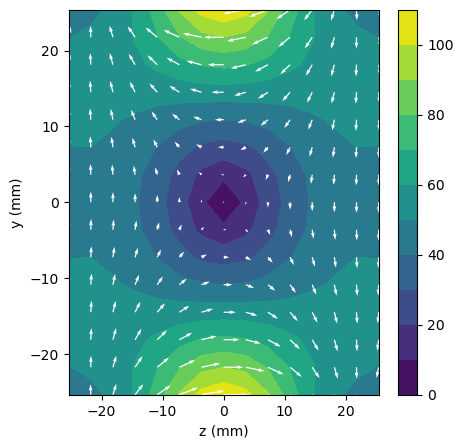

In [4]:
plt.figure(figsize=(5,5))
plot = plt.contourf(zplot*1e3, yplot*1e3, Bmag*1e4, extent=[yplot[0],yplot[-1],zplot[0],zplot[-1]], origin='lower', levels=10)
plt.quiver(zplot*1e3, yplot*1e3, Bz, By, color='white')
plt.xlabel('z (mm)')
plt.ylabel('y (mm)')
plt.colorbar(plot)

In [5]:
def line(x, a, b):
    return a*(x)+b

gradient: -35.032502418560604 G/cm


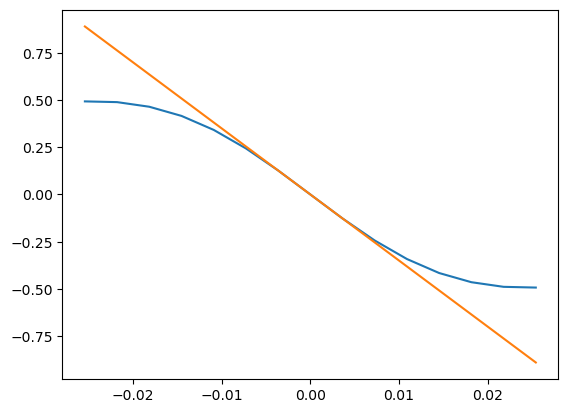

In [6]:
popt, pcov = curve_fit(line, yplot[6:-6], By[8,:][6:-6]*1e4/1e2)
plt.plot(yplot, By[8,:]*1e4/1e2)
plt.plot(yplot, line(yplot, *popt))
print('gradient:', popt[0], 'G/cm')

In [7]:
yplot = np.linspace(-0.3*inch, 0.3*inch, 15)
xplot = np.linspace(-0.3*inch, 0.3*inch, 15)

rb = np.array([[np.array([xx,yy,0]) for yy in yplot] for xx in xplot])

B = np.array([[Bfield(rb[j][i], num) for i in range(len(yplot))] for j in range(len(xplot))]).transpose()
By = B[:,:][1]
Bx = B[:,:][0]
Bz = B[:,:][2]
Bmag = np.sqrt(By**2+Bx**2+Bz**2)

C:\Users\klab\anaconda3\lib\site-packages\matplotlib\quiver.py:646: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
C:\Users\klab\anaconda3\lib\site-packages\matplotlib\quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


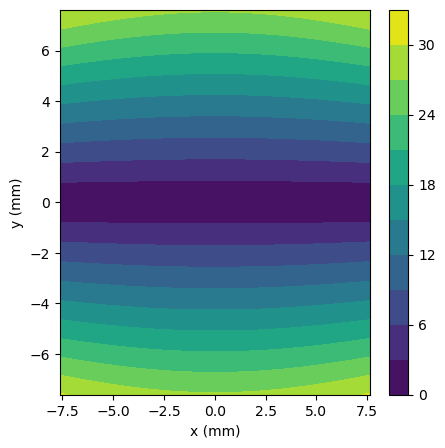

In [8]:
plt.figure(figsize=(5,5))
plot=plt.contourf(xplot*1e3, yplot*1e3, Bmag*1e4, extent=[yplot[0],yplot[-1],xplot[0],xplot[-1]], origin='lower', levels=10)
plt.quiver(xplot*1e3, yplot*1e3, Bx, By, color='white')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.colorbar(plot)

In [9]:
num_array = np.linspace(1, 6, 10, endpoint=True)
grad_array = []

for num in num_array:
    yplot = np.linspace(-1*inch, 1*inch, 15)
    zplot = np.linspace(-1*inch, 1*inch, 15)

    rb = np.array([[np.array([0,yy,zz]) for yy in yplot] for zz in zplot])

    B = np.array([[Bfield(rb[j][i], num) for i in range(len(yplot))] for j in range(len(zplot))]).transpose()
    Bx = B[:,:][0]
    By = B[:,:][1]
    Bz = B[:,:][2]
    Bmag = np.sqrt(By**2+Bz**2+Bx**2)
    
    popt, pcov = curve_fit(line, yplot[6:-6], By[8,:][6:-6]*1e4/1e2)
    grad_array.append(popt[0])

In [10]:
conv_grad = np.mean(np.divide(grad_array, num_array))

# Monte Carlo

In [11]:
L = 1
S = 0
J = 1
I = 1/2
F = 3/2

gJ = 3/2 + (S*(S+1) - L*(L+1)) / 2 / J / (J+1)  
gF = (F*(F+1) + J*(J+1) - I*(I+1)) / 2 / F / (F+1) * gJ

In [12]:
x = np.array([1,0,0])
y = np.array([0,1,0])
z = np.array([0,0,1])

In [13]:
def intensity(r, kj, w, P):
    rj = np.zeros(3)
    return 2*P/np.pi/w**2*np.exp( - 2*np.sum(np.square(np.cross(r-rj, kj/k)))/w**2 ) 

In [14]:
#http://arxiv.org/abs/0905.2897v1
#https://journals.aps.org/pra/abstract/10.1103/PhysRevA.46.4082
def Fj(r, v, kj, w, P, Delta, s, num):
    a = hbar*k*Gamma/m171/2
    betaj = intensity(r, kj, w, P)/Isat
    
    B = Bfield(r, num)
    Bmag = np.sqrt(np.sum(np.square(B)))
    xi = np.dot(kj/k, B/Bmag)
    eta = [ (1+s*xi)**2/4, (1-xi**2)/2, (1-s*xi)**2/4 ]
    
    acc = a*betaj * (kj/k) * np.sum(
    [eta[idx] / (1 + betaj + 4*(Delta/Gamma - np.dot(kj, v)/Gamma - mB*gF*n*Bmag/hbar/Gamma)**2) for idx, n in enumerate([-1, 0, 1]) ]
    )
    
    return (acc+gravity)*m171

In [15]:
def RK4MC(r0, v0, f, kj, w, P, Delta, s, num):
    rn, vn = np.zeros((N,3)), np.zeros((N,3))
    rn[0], vn[0] = r0, v0
    for n in range(N-1):
        k1, l1 = dt*f(rn[n], vn[n], kj, w, P, Delta, s, num)/m171,  dt*vn[n]
        k2, l2 = dt*f(rn[n] + l1/2, vn[n] + k1/2, kj, w, P, Delta, s, num)/m171, dt*(vn[n] + k1/2)
        k3, l3 = dt*f(rn[n] + l2/2, vn[n] + k2/2, kj, w, P, Delta, s, num)/m171, dt*(vn[n] + k2/2)
        k4, l4 = dt*f(rn[n] + l3, vn[n] + k3, kj, w, P, Delta, s, num)/m171, dt*(vn[n] + k3)
        rn[n+1] = rn[n] + (1/6)*(l1 + 2*l2 + 2*l3 + l4)
        vn[n+1] = vn[n] + (1/6)*(k1 + 2*k2 + 2*k3 + k4) #+ np.array([np.random.normal(0,vd,Natoms),
                                                         #         np.random.normal(0,vd,Natoms),
                                                          #       np.random.normal(0,vd,Natoms)])/np.sqrt(3)
    #cFrac = captureFrac(Natoms,rn)
    #print('capture fraction = {:.3f}'.format(cFrac))
    return rn, vn, f(rn[n], vn[n], kj, w, P, Delta, s, num)

In [29]:
def MB_speed(v,m,T):
    """ Maxwell-Boltzmann speed distribution for speeds """
    return (m/(2*np.pi*kB*T))**1.5 * 4*np.pi * v**2 * np.exp(-m*v**2/(2*kB*T))

Tl = 925
def MBsample(Tl):
    i = 0
    dv = 0.1
    v = np.arange(0, 600, dv)
    
    while i<1:
        vi = np.random.choice(v)
        y = MB_speed(vi,m171,Tl)
        eps = np.random.random()
        if eps<y*dv:
            i = i+1
        else:
            i=i
    return vi

In [30]:
_lambda = 399e-9
Gamma = 2*np.pi*30e6
Isat = 60e-3/1e-4
P = 100e-3
w = 5e-3
m171 = 171*u

k= 2*np.pi/_lambda
kj = k*(-y)


gravity = g*(-y)

In [31]:
N=150
dt = 1e-5
Delta= -10*Gamma
num = 3
r0 = np.array([0.,-55e-3, 0.])
s=0

Tl = 925
v_fin = []
p_fin = []

for Natom in tqdm.tqdm(range(5000)):
    r = r0
    vy0 = MBsample(Tl)
    v0 = np.array([0, vy0, 0])
    v = v0
    rn, vn, fn = RK4MC(r, v, Fj, kj, w, P, Delta, s, num)
    v_fin.append(vn[-1][1])

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [10:07<00:00,  8.23it/s]


Text(0.5, 0, 'final velocity')

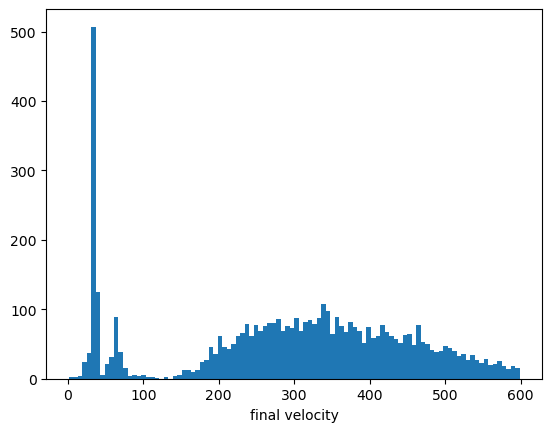

In [37]:
plt.hist(v_fin, bins = 100)
#plt.xlim(0, 100)
plt.xlabel('final velocity')

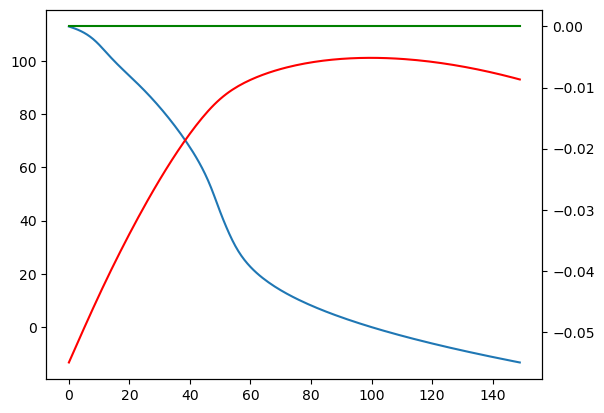

In [19]:
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(np.array(vn)[:,1])
ax2.plot(np.array(rn)[:,1], c='r')
ax2.plot(np.array(rn)[:,2], c='g')

In [20]:
N = 150
dt = 1e-5
Delta_ls = np.linspace(-30*Gamma, 0, 20)

num = 3
r0 = np.array([0.,-55e-3, 0.])
s=0
vy0_ls = np.linspace(1, 300, 20)

vfin = np.zeros([20, 20])
for i, Delta in enumerate(Delta_ls):
    for j, vy0 in enumerate(vy0_ls):
        
        v0 = np.array([0, vy0, 0])

        r = r0
        v = v0

        rn, vn, fn = RK4MC(r, v, Fj, kj, w, P, Delta, s, num)
        
        vfin[i][j] = vn[-1][1]

Text(0.5, 0, 'initial velocity [m/s]')

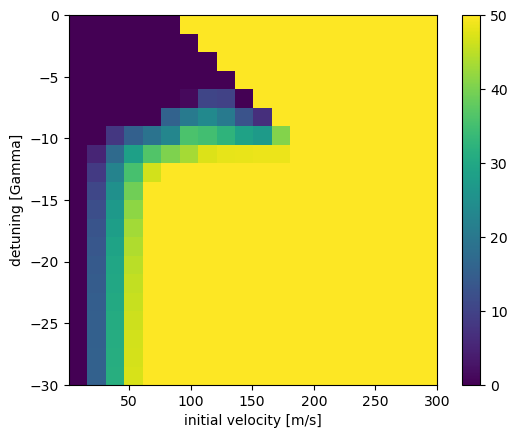

In [21]:
plt.imshow(vfin, origin='lower', vmin=0,vmax = 50, extent = [min(vy0_ls), max(vy0_ls), min(Delta_ls)/Gamma, max(Delta_ls)/Gamma], aspect = 10)
plt.colorbar()
plt.ylabel('detuning [Gamma]')
plt.xlabel('initial velocity [m/s]')

In [22]:
N = 150
dt = 1e-5
Delta_ls = np.linspace(-30*Gamma, 0, 20)

num_ls = np.linspace(1, 8, 20)
r0 = np.array([0.,-55e-3, 0.])
s=0
vy0 = 150
v0 = np.array([0, vy0, 0])

vfin = np.zeros([20, 20])
for i, Delta in enumerate(Delta_ls):
    for j, num in enumerate(num_ls):
        
        r = r0
        v = v0

        rn, vn, fn = RK4MC(r, v, Fj, kj, w, P, Delta, s, num)
        
        vfin[i][j] = vn[-1][1]

Text(0.5, 0, 'gradient in centre [G/cm]')

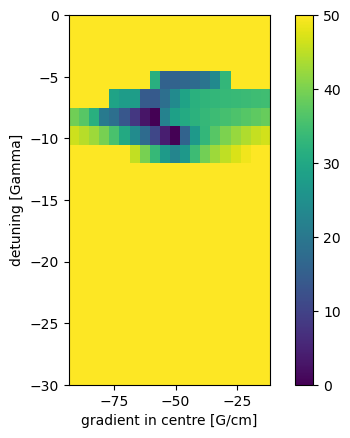

In [23]:
plt.imshow(vfin, origin='lower', vmin = 0, vmax = 50, extent = [min(num_ls*conv_grad), max(num_ls*conv_grad), min(Delta_ls)/Gamma, max(Delta_ls)/Gamma], aspect = 5)
plt.colorbar()
plt.ylabel('detuning [Gamma]')
plt.xlabel('gradient in centre [G/cm]')

In [24]:
_lambda = 399e-9
Gamma = 2*np.pi*30e6
Isat = 60e-3/1e-4
w = 5e-3
m171 = 171*u
Delta = -10*Gamma
num = 3

k= 2*np.pi/_lambda
kj = k*(-y)
rj = np.zeros(3)

gravity = g*(-y)

In [26]:
N = 150
dt = 1e-5
P_ls = np.linspace(1, 300, 20)*1e-3


r0 = np.array([0.,-55e-3, 0.])
s=0
vy0_ls = np.linspace(1, 300, 20)

vfin = np.zeros([20, 20])
for i, P in enumerate(P_ls):
    for j, vy0 in enumerate(vy0_ls):
        
        v0 = np.array([0, vy0, 0])

        r = r0
        v = v0

        rn, vn, fn = RK4MC(r, v, Fj, kj, w, P, Delta, s, num)
        
        vfin[i][j] = vn[-1][1]

Text(0.5, 0, 'initial velocity [m/s]')

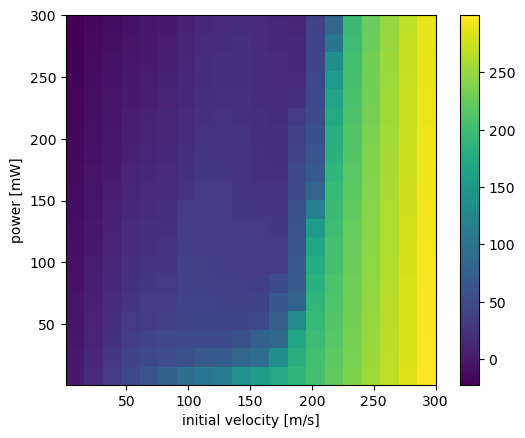

In [30]:
plt.imshow(vfin, origin='lower',extent = [min(vy0_ls), max(vy0_ls), min(P_ls)*1e3, max(P_ls)*1e3], aspect = 1)
plt.colorbar()
plt.ylabel('power [mW]')
plt.xlabel('initial velocity [m/s]')